### Importing all the required libraries

In [ ]:
# importing all the required libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch.distributions 

from PIL import Image
import torchvision.utils
import numpy as np
import matplotlib.pyplot as plt

# checking for device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Downloading and loading dataset


Extracting MANIST_Data/MNIST/raw/train-images-idx3-ubyte.gz to MANIST_Data/MNIST/raw




Extracting MANIST_Data/MNIST/raw/train-labels-idx1-ubyte.gz to MANIST_Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MANIST_Data/MNIST/raw/t10k-images-idx3-ubyte.gz to MANIST_Data/MNIST/raw




Extracting MANIST_Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MANIST_Data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([100, 1, 28, 28])
<class 'torchvision.datasets.mnist.MNIST'>


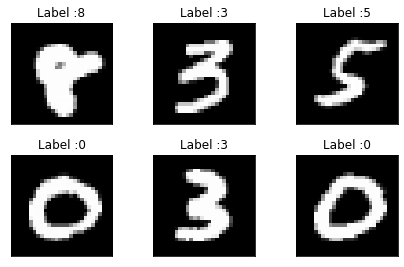

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

#downloading mnist dataset
train_data = MNIST('MANIST_Data', download = True,train = True, transform = transform) 
test_data =MNIST('MANIST_Data', download = True, train= False, transform = transform)

#Loading the data in data loader
BATCH_SIZE = 100
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE ,shuffle= True)
test_dataloader = DataLoader(test_data, batch_size= BATCH_SIZE, shuffle = True)

# showing some of the data samples
examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data.shape)
print(type(train_data))
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title('Label :' + str(int(example_targets[i])))
  plt.xticks([])
  plt.yticks([])
fig.show()

### Creating Encoder and Decoder class for VAE

In [ ]:
# class for encoder

input_size = output_size = 28*28
hidden_size = 512
latent_size = 2
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, output_size):
        super(Encoder,self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, latent_size)
        self.layer3 = nn.Linear(hidden_size, latent_size)
        
        self.normal = torch.distributions.Normal(0,1)
        self.normal.loc = self.normal.loc.cuda()
        self.normal.scale = self.normal.scale.cuda()

        self.kl_divergance = 0

    def forward(self, x):
        out = torch.flatten(x, start_dim=1)
        out = self.layer1(out)
        out = F.relu(out)
        mean =  self.layer2(out)
        out = self.layer3(out)
        variance = torch.exp(out)
        
        self.kl_divergence = (variance**2 + mean**2 - torch.log(variance) - 1/2).sum()

        output = mean + variance*self.normal.sample(mean.shape)
        return output

# class for decoder
class Decoder(nn.Module):
    def __init__(self,input_size, hidden_size ,latent_size, output_size):
        super(Decoder,self).__init__()

        self.layer1 = nn.Linear(latent_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.layer1(x)
        out = F.relu(out)
        out = self.layer2(out)
        output = torch.sigmoid(out)

        return output.reshape(-1,1,28,28)


### Class for Variational autoencoder i.e combining encoder and decoder

In [ ]:
# class for VAE
class VAE(nn.Module):
    def __init__(self, input_size,hidden_size ,latent_size, output_size):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_size, hidden_size ,latent_size, output_size)
        self.decoder = Decoder(input_size, hidden_size ,latent_size, output_size)

    def forward(self,x):
        out = self.encoder(x)
        out = self.decoder(out)

        return out

### Training Variational autoencoder

In [ ]:
#Training VAE

vae = VAE(input_size, hidden_size ,latent_size, output_size).to(device)

epochs = 25
learning_rate = 0.001
optimizer = torch.optim.Adam(vae.parameters(), lr = learning_rate)

losses = []
for i in range(epochs):
    for images, labels in train_dataloader:
        x = images.to(device)
        optimizer.zero_grad()
        x_hat = vae(x)
        loss = ((x-x_hat)**2).sum() + vae.encoder.kl_divergence 
        loss.backward()
        optimizer.step()

    losses.append(loss)



### Plotting graph between loss function and number of epochs

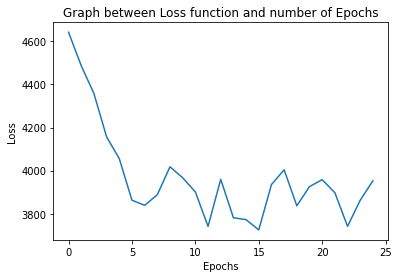

In [ ]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Graph between Loss function and number of Epochs")
plt.plot(losses)
plt.show()


### Saving and loading the trained VAE model

In [ ]:
# saving model
PATH = 'saved_VAE_model.pth'
torch.save(vae, PATH)



In [ ]:
PATH = 'saved_VAE_model.pth'
#loading the model
vae_model = torch.load(PATH)

### Plotting the latent space obtained from encoder

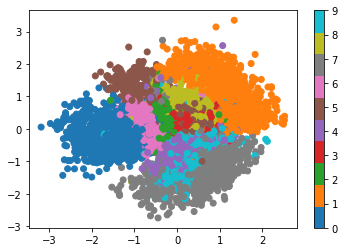

In [ ]:

for i, (x, y) in enumerate(train_dataloader):
    z = vae_model.encoder(x.to(device))
    z = z.to('cpu').detach().numpy()
    plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
    if i > 100:
        plt.colorbar()
        break


In [ ]:

x, y = train_dataloader.__iter__().next()
first_value = x[y == 7][1].to(device) 
second_value = x[y == 2][1].to(device)   

inter_1 = vae.encoder(first_value)
inter_2 = vae.encoder(second_value)

z = torch.stack([inter_1 + (inter_2 - inter_1)*t for t in np.linspace(0, 1, 100)])

interpolate_list = vae.decoder(z)
interpolate_list = interpolate_list.to('cpu').detach().numpy()*255

images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
images_list = images_list + images_list[::-1] 

images_list[0].save(
    f'{"VAE"}.gif',
    save_all=True,
    append_images=images_list[1:],
    loop=1)

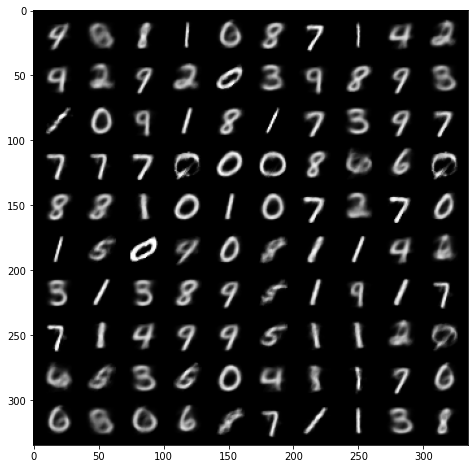

In [ ]:

def show_image(img):
    img = img.clamp(0,1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent_space = torch.randn(100, latent_size, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent_space)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

https://avandekleut.github.io/vae/


https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=Okn4RaR5aDn-


https://www.youtube.com/watch?v=IXsA5Rpp25w&ab_channel=KapilSachdeva

https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb
